# 2D simple synthetic dataset using function template to load data from file sequentially

In this tutorial we will generate a small dataset, save it into a netCDF file use a specific function template to load the data into memory sequentially at runtime (useful for large memory applications). 

## Loading and configuring data

We first import the required libraries, including the custom libraries 
- `from pyspod.spod_low_storage import SPOD_low_storage`
- `from pyspod.spod_low_ram     import SPOD_low_ram`
- `from pyspod.spod_streaming   import SPOD_streaming`

that contain three different implementations of the SPOD algorithm, the first requiring low storage memory (intended for large RAM machines or small amount of data), the second requiring low RAM (intended for large dataset or small RAM machines), and the third being a streaming algorithm, that required little amount of memory (both storage and RAM) but runs typically slower than the other two.

Note that we also import the custom library 
- `import library.weights as weights`

that implements the various weight matrices that might be required when performing SPOD. 

In [4]:
import os
import sys
import xarray as xr
import numpy  as np

# Import library specific modules
sys.path.append("../../../")
from pyspod.spod_low_storage import SPOD_low_storage
from pyspod.spod_low_ram     import SPOD_low_ram
from pyspod.spod_streaming   import SPOD_streaming
import pyspod.weights as weights

# Current working path
CWD = os.getcwd()

We then create out simple 2D synthetic dataset. 

In [5]:
# Let's create some 2D syntetic data
# and store them into a variable called p
variables = ['p']
x1 = np.linspace(0,10,100)
x2 = np.linspace(0, 5, 50)
xx1, xx2 = np.meshgrid(x1, x2)
t = np.linspace(0, 200, 1000)
s_component = np.sin(xx1 * xx2) + np.cos(xx1)**2 + np.sin(0.1*xx2)
# s_component = s_component.T
t_component = np.sin(0.1 * t)**2 + np.cos(t) * np.sin(0.5*t)
p = np.empty((t_component.shape[0],)+s_component.shape)
for i, t_c in enumerate(t_component):
	p[i] = s_component * t_c

# We now save the data into netCDF format
ds = xr.Dataset(
        {"p": (("time", "x1", "x2"), p)},
        coords={
            "x1": x2,
            "x2": x1,
            "time": t,
        },
    )
ds.to_netcdf("data.nc")

We now need to load the data (that we just stored in the netCDF file `data.nc`) in a format that is suitable to the `PySPOD` library, that is

  - first dimension must correspond to the number of time snapshots (1000 in our case)
  - last dimension should corresponds to the number of variables (1 in our case)
  - the remaining dimensions corresponds to the spatial dimensions (50, and 100 in our case, that correspond to the first and second coordinate).

In order to perform this step, we have two options. 
  1. Provide a function that reads the data and pass it to the PySPOD class under the argument `data_handler`, along with the path to the file containing the data.
  2. Load all the data in RAM and pass it to the PySPOD class (in this case, the argument `data_handler` will be set to `False`.

The first approach allows the efficient processing of large files that may not fit in RAM, and data is loaded sequentially when needed, thereby reducing significantly the amount of RAM required. The second approach is RAM intensive but may be faster.

Let's explore the first method, and define a function that can load the data for us at run time. The arguments of the reader function must be:

  - data (the path to the file containing our data)
  - t_0 (the start time of a time slice)
  - t_end (the end time of a time slice)
  - variables (the name of the variables contained in the file)

This template is general enough for many applications using netCDF, .mat, and other data files. Our reader function is defined below:

In [6]:
# We now show how to construct a data reader that can be passed
# to the constructor of pyspod to read data sequentially (thereby
# reducing RAM requirements)

# Reader for netCDF
def read_data_netCDF(data, t_0, t_end, variables):
    if t_0 == t_end: ti = [t_0]
    else           : ti = np.arange(t_0,t_end)
    X = np.empty([len(ti), x2.shape[0], x1.shape[0], len(variables)])
    for _,var in enumerate(variables):
        X = np.array(ds[var].isel(time=ti))
    return X
x_nc = read_data_netCDF('data.nc', t_0=0, t_end=t.shape[0], variables=variables)
x_nc_ssn = read_data_netCDF('data.nc', t_0=0, t_end=0, variables=variables)
print('x_nc.shape = ', x_nc.shape)
print('x_nc_ssn.shape = ', x_nc_ssn.shape)

x_nc.shape =  (1000, 50, 100)
x_nc_ssn.shape =  (1, 50, 100)


We can see how the shape of our data is in a `PySPOD` compatible format: 
  - first dimension correspond to time
  - second dimension correspond to first spatial coordinate
  - third dimension corresponds to second spatial coordinate

## Setting required and optional parameters

Once our data is in a shape suitable to the `PySPOD` library, we define the **required** and **optional parameters**. In particular, we define a dictionary of parameters, that will be passed to the constructor of `PySPOD`. 

The required parameters are as follows:
- `dt`: time-sampling of the data (for now this must be constant)
- `nt`: number of time snapshots
- `xdim`: number of spatial dimensions
- `nv`: number of variables
- `n_FFT`: length of FFT blocks
- `n_freq`: number of frequencies
- `n_overlap`: dimension of the overlap region between adjacent blocks
- `mean`: type of mean to be subtracted from the data
- `normalize`: data normalization by data variance
- `savedir`: where to save the data
- `weights`: weights to be used to compute the inner product

The optional parameters are as follows:
- `savefreqs`: number of frequencies to be saved
- `n_modes_save`: number of modes to be saved
- `normavar`: normalize data by variance
- `conf_level`: calculate confidence level of modes
- `savefft`: save FFT blocks to reuse them in the future (to save time)

In [8]:
# Let's define the required parameters into a dictionary
params = dict()

# -- required parameters
params['dt'          ] = 1                	# data time-sampling
params['nt'          ] = t.shape[0]       	# number of time snapshots (we consider all data)
params['xdim'        ] = 2                	# number of spatial dimensions (longitude and latitude)
params['nv'          ] = len(variables)     # number of variables
params['n_FFT'       ] = 100          		# length of FFT blocks (100 time-snapshots)
params['n_freq'      ] = params['n_FFT'] / 2 + 1   			# number of frequencies
params['n_overlap'   ] = np.ceil(params['n_FFT'] * 0 / 100) # dimension block overlap region
params['mean'        ] = 'blockwise' 						# type of mean to subtract to the data
params['normalize'   ] = False        						# normalization of weights by data variance
params['savedir'     ] = os.path.join(CWD, 'results', 'simple_test') # folder where to save results

# -- optional parameters
params['weights']      = None # if set to None, no weighting (if not specified, Default is None)
params['savefreqs'   ] = np.arange(0,params['n_freq']) # frequencies to be saved
params['n_modes_save'] = 3      # modes to be saved
params['normvar'     ] = False  # normalize data by data variance
params['conf_level'  ] = 0.95   # calculate confidence level
params['savefft'     ] = True   # save FFT blocks to reuse them in the future (saves time)

## Running the SPOD analysis

Once we have loaded the data and defined the required and optional parameters, we can perform the analysis. This step is accomplished by calling the `PySPOD` constructor, `SPOD_streaming(X=X, params=params, data_handler=False, variables=variables)` and the `fit` method, `SPOD_analysis.fit()`. 

The `PySPOD` constructor takes `X`, that can either be a `numpy.ndarray` containing the data or the path to the data file , the parameters `params`, a parameter called `data_handler` that can be either `False` or a function to read the data, and `variables` that is the list containing the names of our variables. If, as `data_handler`, we pass `False`, then we need to load the entire matrix of data into RAM, and that must comply with the **PySPOD** input data requirements (i.e. the dimension of the data matrix must correspond to (time $\times$ spatial dimension shape $\times$ number of variables). 

In more detail, the arguments to the constructor are defined as follows:

  - `X`: it can either be a `numpy.ndarray` and contain all data required for the analysis or a `str` containing the path to the data file. If we pass a `numpy.ndarray`, its dimensions must be equal to (time $\times$ spatial dimension shape $\times$ number of variables), and the argument `file_handler` must be set to `False`. If we pass a `str` containing the path to the data file, we need also to provide a data reader through the argument `data_handler`. The data reader must conform to reading the file and storing the data in memory according to the shape of data just described: **(number of time snapshots $\times$ shape of spatial dimensions $\times$ number of variables)**. Note that the template for the data reader must have as first argument the path to the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. An example of data reader was provided above. You can readily modify it according to your needs. See the sections above for a template example of the data reader function.
  - `params`: must be a dictionary and contains the parameters that we have just defined. 
  - `data_handler`: can be either `False` or a function handler. If it is a function handler, it must hold the function to read the data. The template for the function to read the data must have as first argument the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. See hour data reader as an example and modify it according to your needs.
  - `variables`: is a list containing our variables. 

The `fit()` method returns a `PySPOD` object containg the results. 

In [9]:
# Initialize libraries by using data_handler for the low storage algorithm
spod_ls = SPOD_low_storage(
    X=os.path.join(CWD,'data.nc'),
    params=params,
    data_handler=read_data_netCDF,
    variables=variables)
spod_ls.fit()


SPOD parameters
------------------------------------
Spectrum type             : one-sided (real-valued signal)
No. of snaphots per block :  100
Block overlap             :  0
No. of blocks             :  10
Windowing fct. (time)     :  hamming
Weighting fct. (space)    :  uniform
Mean                      :  blockwise
Time-step                 :  1
Number of Frequencies     :  51
------------------------------------

DATA MATRIX DIMENSIONS
------------------------------------
Problem size          :  0.037252902984619196 GB. (double)
data matrix dimensions:         (1, 50, 100, 1)
Make sure that first column of data matrix is time and last column is number of variables. 
First column dimension: 1 must correspond to number of time snapshots.
Last column dimension: 1 must correspond to number of variables.
------------------------------------
 
Calculating temporal DFT (low_storage)
--------------------------------------
RAM available =  13.907077789306662
RAM required  =  0.0149011611

computing frequencies:   0%|          | 0/51 [00:00<?, ?it/s]../../../pyspod/spod_low_storage.py:163: RuntimeWarning: invalid value encountered in sqrt
  Psi = np.matmul(Q_hat_f, np.matmul(V, np.diag(1. / np.sqrt(L) / np.sqrt(self._n_blocks))))
../../../pyspod/spod_low_storage.py:163: RuntimeWarning: divide by zero encountered in true_divide
  Psi = np.matmul(Q_hat_f, np.matmul(V, np.diag(1. / np.sqrt(L) / np.sqrt(self._n_blocks))))
../../../pyspod/spod_low_storage.py:163: RuntimeWarning: invalid value encountered in matmul
  Psi = np.matmul(Q_hat_f, np.matmul(V, np.diag(1. / np.sqrt(L) / np.sqrt(self._n_blocks))))
computing frequencies: 100%|██████████| 51/51 [00:00<00:00, 338.08it/s]

--------------------------------------
 
Calculating SPOD (low_storage)
--------------------------------------
--------------------------------------
 
Results saved in folder  /Users/gian/GIT-GM/pyspod/tutorials/basic/methods_comparison_file/results/simple_test/nfft100_novlp0_nblks10
Elapsed time:  0.6721620559692383 s.


## Postprocessing and visualizing results

The results are stored in a `PySPOD` objcet that is composed by: 
- a set of eigenvalues per each frequency computed, and 
- a set of modes, per each frequency computed. 

In order to visualize them, we can use the built-in plotting functionalities of `PySPOD`.
We first visualize the original data. (Note that to be able to use `generate_2D_data_video`, you need ffmpeg installed in your local machine).

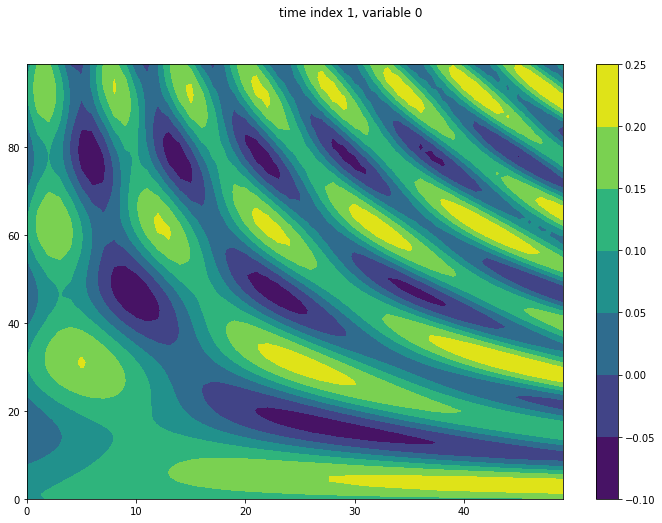

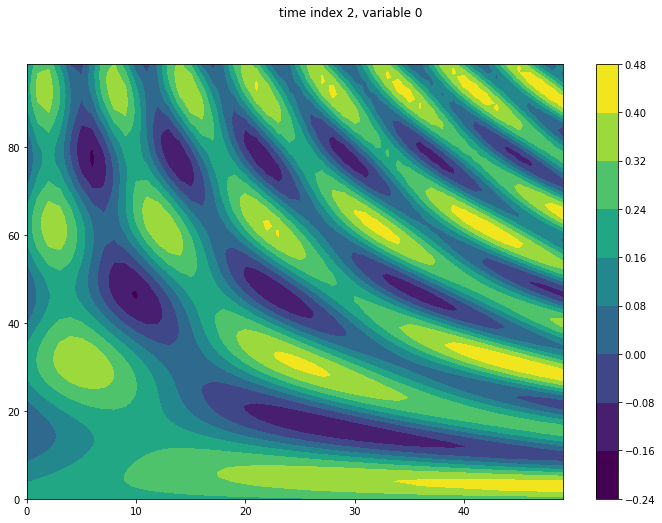

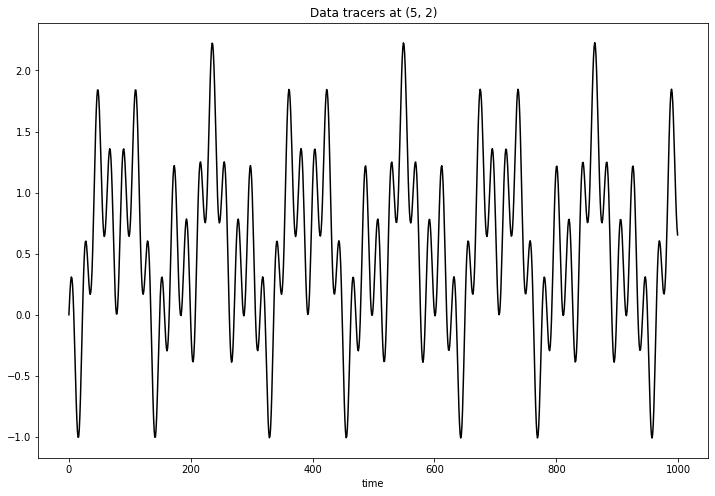

In [10]:
# Let's plot the data
spod_ls.plot_2D_data(time_idx=[1,2])
spod_ls.plot_data_tracers(coords_list=[(5,2.5)], time_limits=[0,t.shape[0]])
spod_ls.generate_2D_data_video(sampling=10, time_limits=[0,t.shape[0]])

We can then visualize the **eigenvalues in the complex plane**, and as a function of frequency and period using the built-in functions `plot_eigs`, `plot_eigs_vs_frequency`, and `plot_eigs_vs_period`, that are part of the `postprocessing` module. 

- RAM required for loading all modes ~ 0.004470348358154304 GB
- Available RAM memory               ~ 13.730297088623068 GB


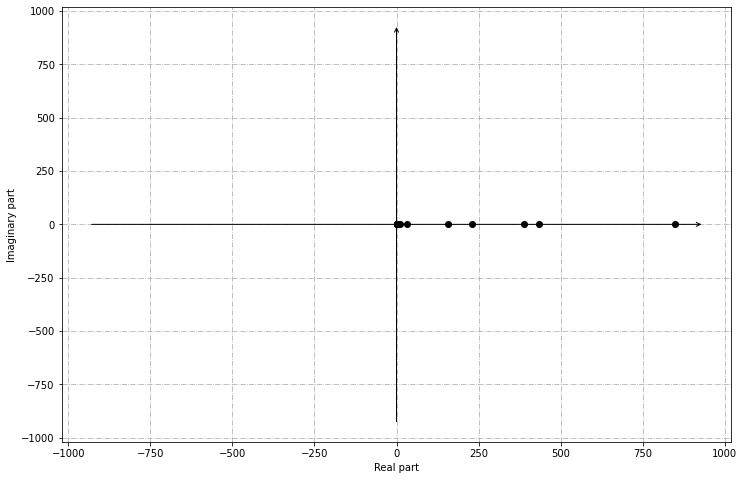

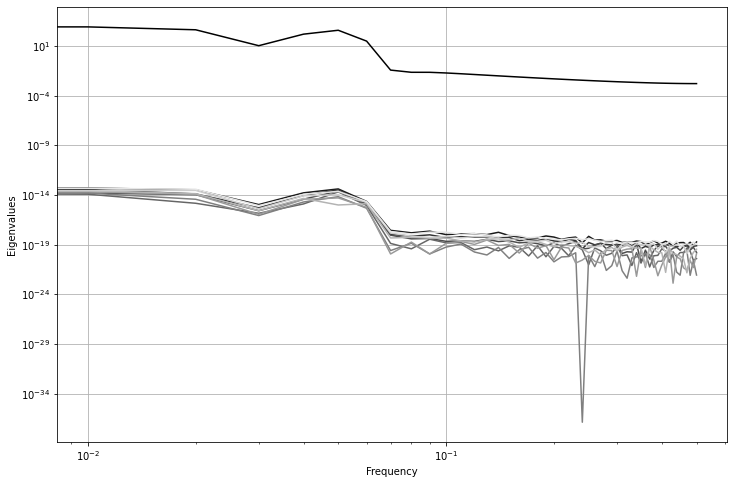

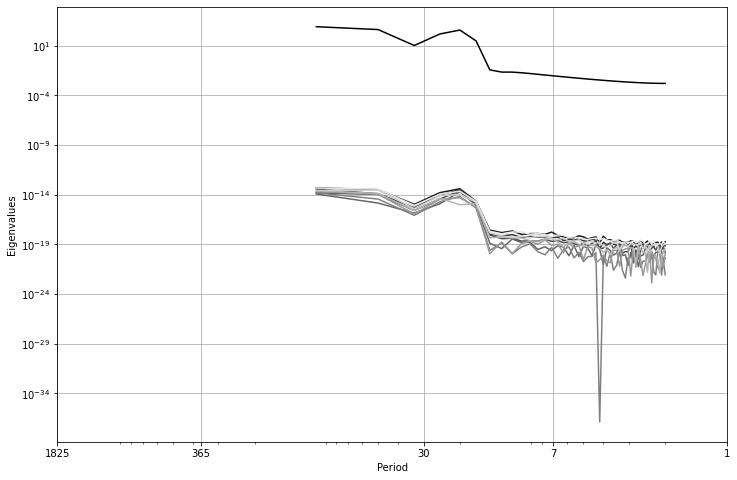

In [11]:
# Show results
T_approx = 10 # approximate period = 10 days (in days)
freq = spod_ls.freq
freq_found, freq_idx = spod_ls.find_nearest_freq(freq_required=1/T_approx, freq=freq)
modes_at_freq = spod_ls.get_modes_at_freq(freq_idx=freq_idx)
spod_ls.plot_eigs()
spod_ls.plot_eigs_vs_frequency(freq=freq)
spod_ls.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30, 365, 1825])

We can then plot the **2D modes for a given frequency** using the built-in function `plot_2D_modes_at_frequency` implemented in the `postprocessing` module.

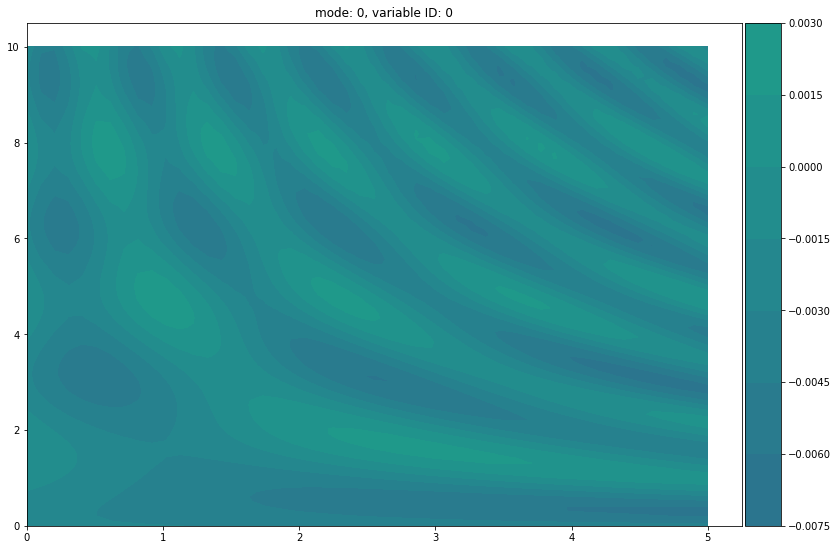

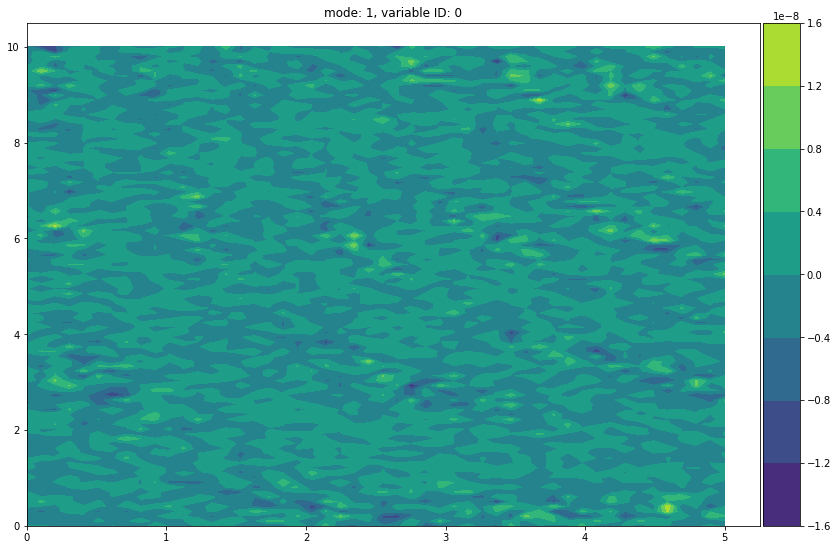

In [12]:
spod_ls.plot_2D_modes_at_frequency(
	freq_required=freq_found,
    freq=freq,
    x1=x2,
    x2=x1,
    modes_idx=[0,1],
    vars_idx=[0])

We can also use the two other version of SPOD to run our analysis, namely `SPOD_low_ram` and `SPOD_streaming`. 
The first one, `SPOD_low_ram`, can be called as follows

In [13]:
# Let's try the low_ram algorithm
spod_ram = SPOD_low_ram(
    X=os.path.join(CWD,'data.nc'),
    params=params,
    data_handler=read_data_netCDF,
    variables=variables)
spod_ram.fit()

computing frequencies:   0%|          | 0/51 [00:00<?, ?it/s]../../../pyspod/spod_low_ram.py:149: RuntimeWarning: invalid value encountered in sqrt
  Psi = np.matmul(Q_hat_f, np.matmul(V, np.diag(1. / np.sqrt(L) / np.sqrt(self._n_blocks))))
../../../pyspod/spod_low_ram.py:149: RuntimeWarning: divide by zero encountered in true_divide
  Psi = np.matmul(Q_hat_f, np.matmul(V, np.diag(1. / np.sqrt(L) / np.sqrt(self._n_blocks))))
../../../pyspod/spod_low_ram.py:149: RuntimeWarning: invalid value encountered in matmul
  Psi = np.matmul(Q_hat_f, np.matmul(V, np.diag(1. / np.sqrt(L) / np.sqrt(self._n_blocks))))
computing frequencies:  33%|███▎      | 17/51 [00:00<00:00, 167.84it/s]


SPOD parameters
------------------------------------
Spectrum type             : one-sided (real-valued signal)
No. of snaphots per block :  100
Block overlap             :  0
No. of blocks             :  10
Windowing fct. (time)     :  hamming
Weighting fct. (space)    :  uniform
Mean                      :  blockwise
Time-step                 :  1
Number of Frequencies     :  51
------------------------------------

DATA MATRIX DIMENSIONS
------------------------------------
Problem size          :  0.037252902984619196 GB. (double)
data matrix dimensions:         (1, 50, 100, 1)
Make sure that first column of data matrix is time and last column is number of variables. 
First column dimension: 1 must correspond to number of time snapshots.
Last column dimension: 1 must correspond to number of variables.
------------------------------------
 
Calculating temporal DFT (low_ram)
------------------------------------
Checking if blocks are already present ...
block 1/10 is present in:  /

computing frequencies: 100%|██████████| 51/51 [00:00<00:00, 168.36it/s]

------------------------------------
 
Results saved in folder  /Users/gian/GIT-GM/pyspod/tutorials/basic/methods_comparison_file/results/simple_test/nfft100_novlp0_nblks10
Elapsed time:  0.32345008850097656 s.


and visualize the results as before

- RAM required for loading all modes ~ 0.004470348358154304 GB
- Available RAM memory               ~ 13.535923004150412 GB


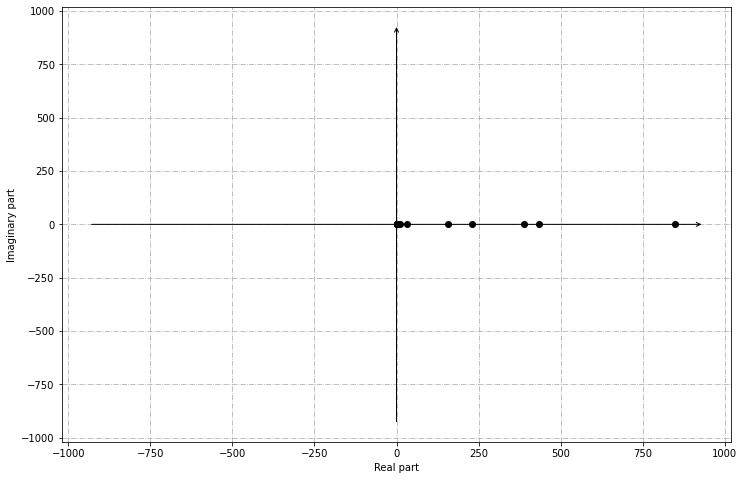

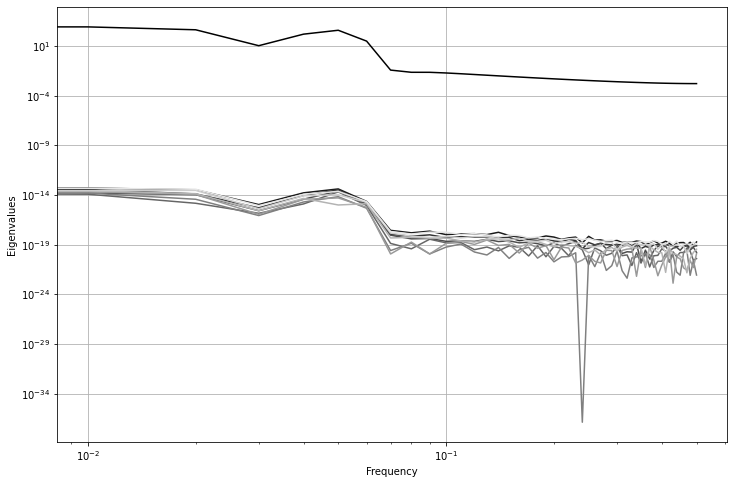

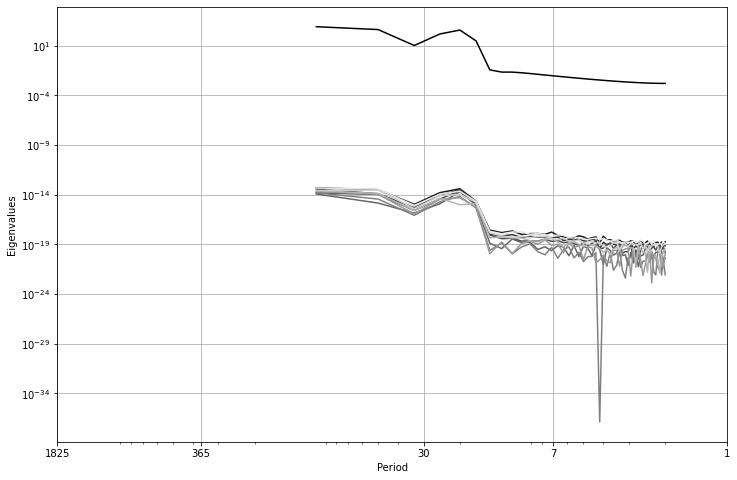

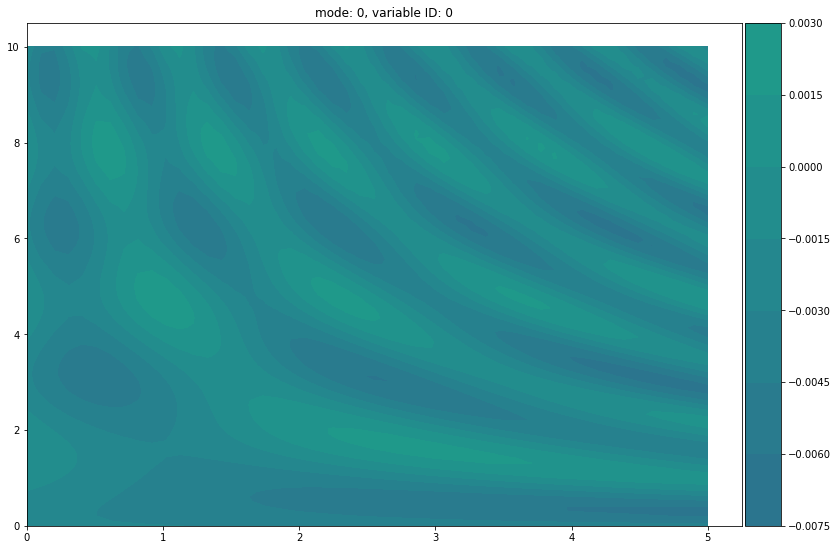

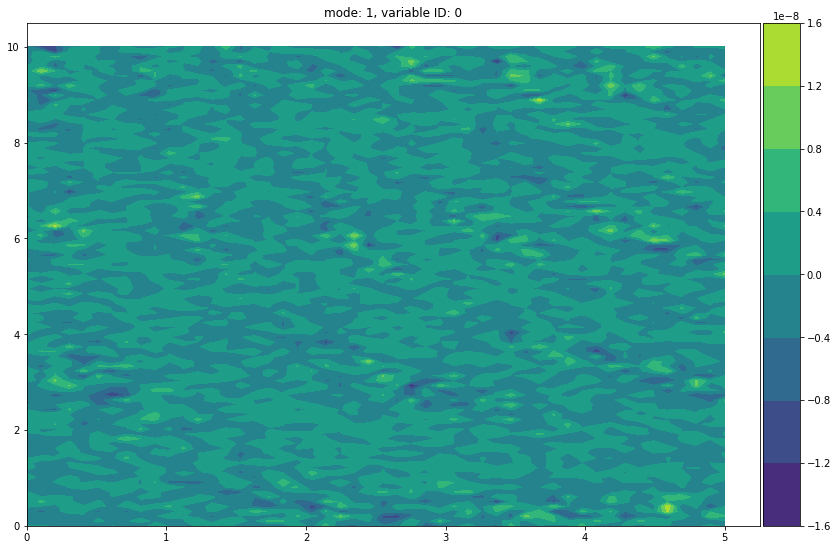

In [14]:
# Show results
T_approx = 10 # approximate period = 10 days (in days)
freq = spod_ram.freq
freq_found, freq_idx = spod_ram.find_nearest_freq(freq_required=1/T_approx, freq=freq)
modes_at_freq = spod_ram.get_modes_at_freq(freq_idx=freq_idx)
spod_ram.plot_eigs()
spod_ram.plot_eigs_vs_frequency(freq=freq)
spod_ram.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30, 365, 1825])
spod_ram.plot_2D_modes_at_frequency(
	freq_required=freq_found,
    freq=freq,
    x1=x2,
    x2=x1,
    modes_idx=[0,1],
    vars_idx=[0])

The second, `SPOD_streaming` can be called as 

In [15]:
# Finally, we can try the streaming algorithm
spod_st = SPOD_streaming(
    X=os.path.join(CWD,'data.nc'),
    params=params,
    data_handler=read_data_netCDF,
    variables=variables)
spod_st.fit()


SPOD parameters
------------------------------------
Spectrum type             : one-sided (real-valued signal)
No. of snaphots per block :  100
Block overlap             :  0
No. of blocks             :  10
Windowing fct. (time)     :  hamming
Weighting fct. (space)    :  uniform
Mean                      :  blockwise
Time-step                 :  1
Number of Frequencies     :  51
------------------------------------

DATA MATRIX DIMENSIONS
------------------------------------
Problem size          :  0.037252902984619196 GB. (double)
data matrix dimensions:         (1, 50, 100, 1)
Make sure that first column of data matrix is time and last column is number of variables. 
First column dimension: 1 must correspond to number of time snapshots.
Last column dimension: 1 must correspond to number of variables.
------------------------------------
 
Calculating temporal DFT (streaming)
------------------------------------


../../../pyspod/spod_streaming.py:89: RuntimeWarning: invalid value encountered in multiply
  mse_prev = np.empty([int(1e3),self._n_modes,self._n_freq], dtype='complex_') * np.nan


--> Updating left singular vectors Time  99  / block  1


../../../pyspod/spod_streaming.py:198: RuntimeWarning: divide by zero encountered in true_divide
  mse_prev[block_i,:,:] = (np.abs(S_hat_prev**2 - self._eigs**2)**2) / (S_hat_prev**2)
../../../pyspod/spod_streaming.py:198: RuntimeWarning: invalid value encountered in true_divide
  mse_prev[block_i,:,:] = (np.abs(S_hat_prev**2 - self._eigs**2)**2) / (S_hat_prev**2)


--> Updating left singular vectors Time  200  / block  2
--> Updating left singular vectors Time  301  / block  3
--> Updating left singular vectors Time  402  / block  4


../../../pyspod/spod_streaming.py:198: RuntimeWarning: overflow encountered in true_divide
  mse_prev[block_i,:,:] = (np.abs(S_hat_prev**2 - self._eigs**2)**2) / (S_hat_prev**2)


--> Updating left singular vectors Time  503  / block  5
--> Updating left singular vectors Time  604  / block  6
--> Updating left singular vectors Time  705  / block  7
--> Updating left singular vectors Time  806  / block  8
--> Updating left singular vectors Time  907  / block  9
--> Data stream ended.
Elapsed time:  4.398266077041626 s.


Where we can again see the results as before

- RAM required for loading all modes ~ 0.004470348358154304 GB
- Available RAM memory               ~ 13.552097320556662 GB


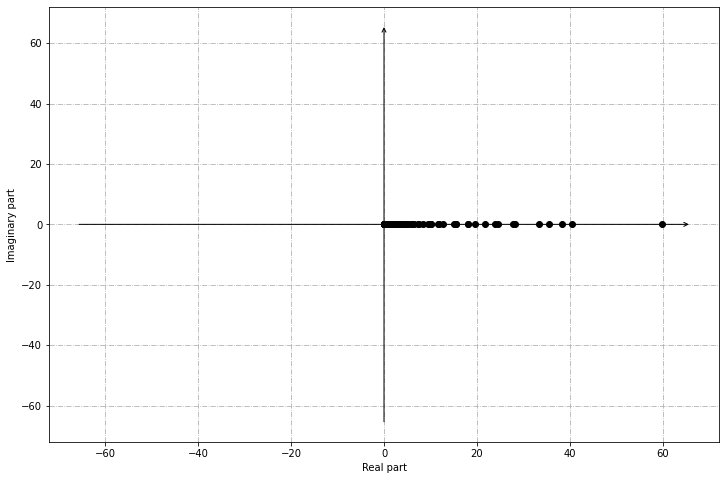

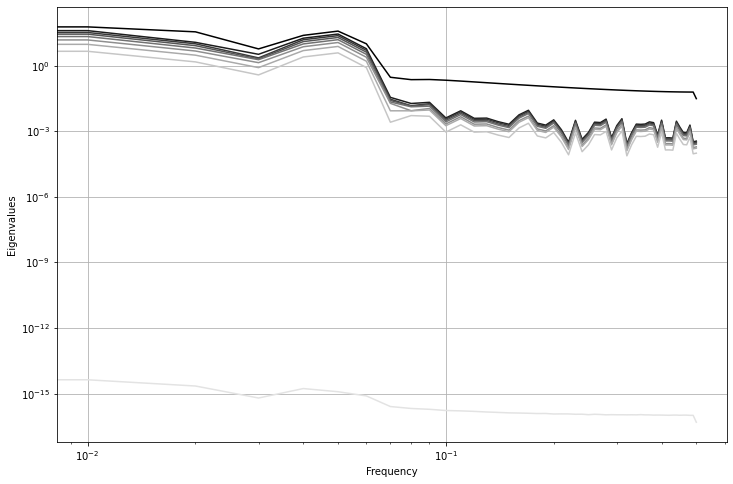

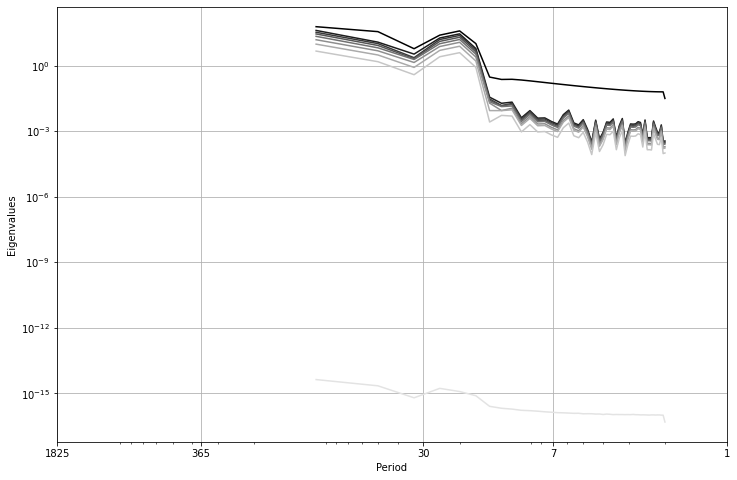

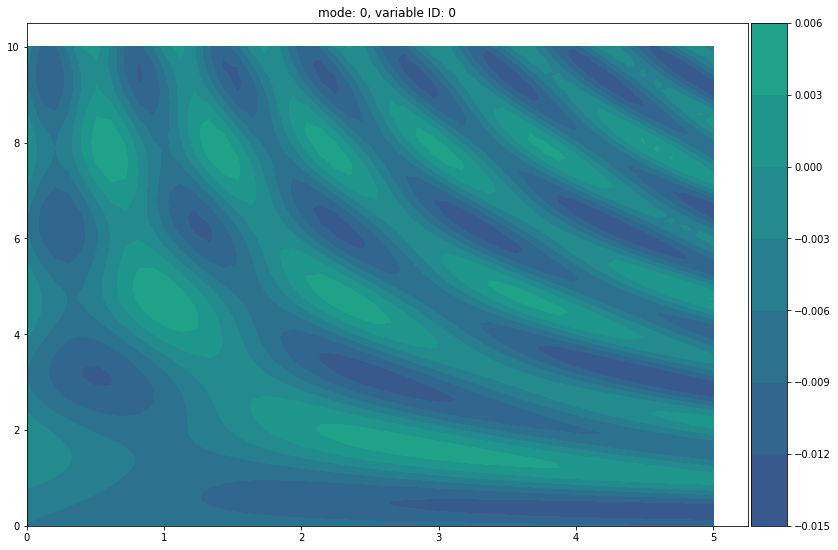

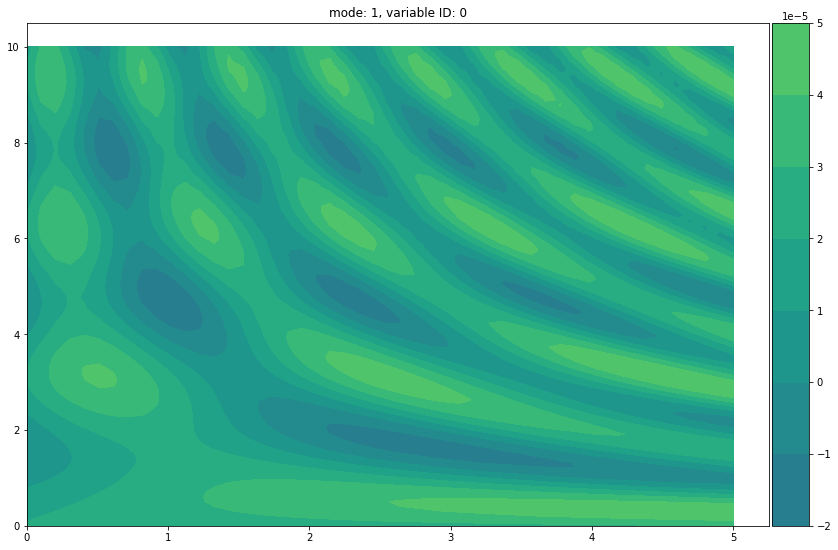

In [16]:
# Show results
T_approx = 10 # approximate period = 10 days (in days)
freq = spod_st.freq
freq_found, freq_idx = spod_st.find_nearest_freq(freq_required=1/T_approx, freq=freq)
modes_at_freq = spod_st.get_modes_at_freq(freq_idx=freq_idx)
spod_st.plot_eigs()
spod_st.plot_eigs_vs_frequency(freq=freq)
spod_st.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30, 365, 1825])
spod_st.plot_2D_modes_at_frequency(
	freq_required=freq_found,
    freq=freq,
    x1=x2,
    x2=x1,
    modes_idx=[0,1],
    vars_idx=[0])

## Final notes

The results are stored in the results folder defined in the parameter `params[savedir]` you specified. We can load the results for both modes and eigenvalues, and use any other postprocessing tool that is more suitable to your application. The files are stored in `numpy` binary format `.npy`. There exists several tools to convert them in `netCDF`, `MATLAB` and several other formats that can be better suited to you specific post-processing pipeline.